In [ ]:
#HW1
REPO_NAME = "dgm_utils"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/PetrMokrov/{REPO_NAME}.git
!pip install ./{REPO_NAME}
!rm -Rf ./{REPO_NAME}

In [3]:
from time import time
from copy import deepcopy
import itertools
from IPython.display import clear_output

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as Tdata
import torch.nn.functional as F
import torch.distributions as TD
import torchvision
from torchvision import transforms
import torchvision.datasets as TVdatasets
from torchvision.utils import save_image, make_grid

import numpy as np
from matplotlib import pyplot as plt

import sys
from tqdm import tqdm

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 0
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# dgm_utils
from dgm_utils import train_model, show_samples, visualize_images
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data
from dgm_utils import StatsManager

def reset_seed():
    OUTPUT_SEED = 0xBADBEEF
    torch.manual_seed(OUTPUT_SEED)
    np.random.seed(OUTPUT_SEED)

reset_seed()

In [ ]:
def draw_grid(grid, figsize=(10, 10), title=None):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.asarray(grid.permute(1, 2, 0).cpu()))

In [ ]:
#1

BATCH_SIZE = 64

def random_color(im):
    hue = 360*np.random.rand()
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

TRANSFORM = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    random_color,
    transforms.Normalize([0.5],[0.5])
])

mnist_train = TVdatasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM)
usps_train = TVdatasets.USPS(root='./data', train=True, download=True, transform=TRANSFORM)

mnist_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
usps_loader = torch.utils.data.DataLoader(usps_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

X_test_fixed = next(iter(mnist_test_loader))[0]
Y_test_fixed = next(iter(usps_test_loader))[0]

del mnist_test_loader, usps_test_loader, mnist_test, usps_test

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17907242.82it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 492609.75it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4545123.28it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3310832.25it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 6579383/6579383 [00:01<00:00, 5294320.80it/s]


100%|██████████| 1831726/1831726 [00:00<00:00, 1908555.96it/s]


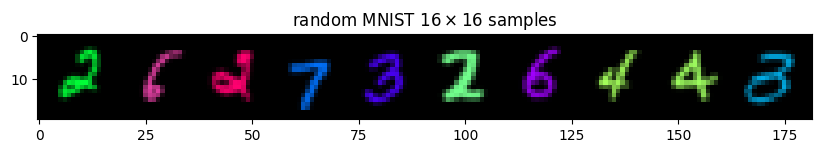

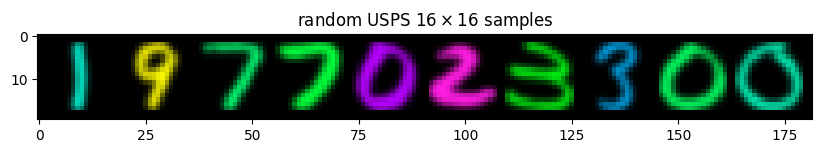

In [ ]:
draw_grid(
    make_grid(next(iter(mnist_loader))[0][:10], nrow=10, normalize=True),
    title=r'random MNIST $16\times 16$ samples')
draw_grid(
    make_grid(next(iter(usps_loader))[0][:10], nrow=10, normalize=True),
    title=r'random USPS $16\times 16$ samples')

In [ ]:
iter_mnist, iter_usps = iter(mnist_loader), iter(usps_loader)

def sample_mnist():
    global iter_mnist, mnist_loader
    try:
        return next(iter_mnist)[0]
    except StopIteration:
        iter_mnist = iter(mnist_loader)
        return next(iter_mnist)[0]

def sample_usps():
    global iter_usps, usps_loader
    try:
        return next(iter_usps)[0]
    except StopIteration:
        iter_usps = iter(usps_loader)
        return next(iter_usps)[0]

In [ ]:
#2

In [ ]:
# Generator from domain X to domain Y

G_XY = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 3, kernel_size=5, padding=2),
)

# Generator from domain Y to domain X

G_YX = deepcopy(G_XY)

G_XY = G_XY.to(DEVICE)
G_YX = G_YX.to(DEVICE)

In [ ]:
# Discriminator for domain X

class SimplePatchDiscriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4, padding=1, stride=2),
            nn.InstanceNorm2d(128), # 128 x 8 x 8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, padding=1, stride=2),
            nn.InstanceNorm2d(256), #  256 x 4 x 4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, padding=1, stride=2),
            nn.InstanceNorm2d(512), # 512 x 2 x 2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=1, padding=0), # 1 x 2 x 2
        )
        self.output_shape = (1, 2, 2)

    def forward(self, x):
        return self.net(x)

# Discriminator for domain X

D_X = SimplePatchDiscriminator()

# Discriminator for domain Y

D_Y = SimplePatchDiscriminator()

D_X = D_X.to(DEVICE)
D_Y = D_Y.to(DEVICE)

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.026)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)

D_Y.apply(weights_init_normal)
D_X.apply(weights_init_normal)
G_XY.apply(weights_init_normal)
G_YX.apply(weights_init_normal)

Sequential(
  (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (3): ReLU(inplace=True)
  (4): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU(inplace=True)
  (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (7): ReLU(inplace=True)
  (8): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (11): ReLU(inplace=True)
  (12): Conv2d(128, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [ ]:
#3

LR = 2e-4
BETA1 = 0.5
BETA2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_XY.parameters(), G_YX.parameters()), lr=LR, betas=(BETA1, BETA2)
)
optimizer_D_X = torch.optim.Adam(D_X.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_D_Y = torch.optim.Adam(D_Y.parameters(), lr=LR, betas=(BETA1, BETA2))

In [ ]:
def show_cyclegan_images(step):
    """Saves a generated sample from the test set"""
    G_XY.eval()
    G_YX.eval()
    real_X = torch.tensor(X_test_fixed[:8], device=DEVICE)
    real_Y = torch.tensor(Y_test_fixed[:8], device=DEVICE)
    fake_X = G_YX(real_Y).clip(-1., 1.)
    fake_Y = G_XY(real_X).clip(-1., 1.)
    # Arange images along x-axis
    real_X = make_grid(real_X, nrow=8, normalize=True)
    real_Y = make_grid(real_Y, nrow=8, normalize=True)
    fake_X = make_grid(fake_X, nrow=8, normalize=True)
    fake_Y = make_grid(fake_Y, nrow=8, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_X, fake_Y, real_Y, fake_X), 1)
    draw_grid(image_grid, title='Step: {}'.format(step))

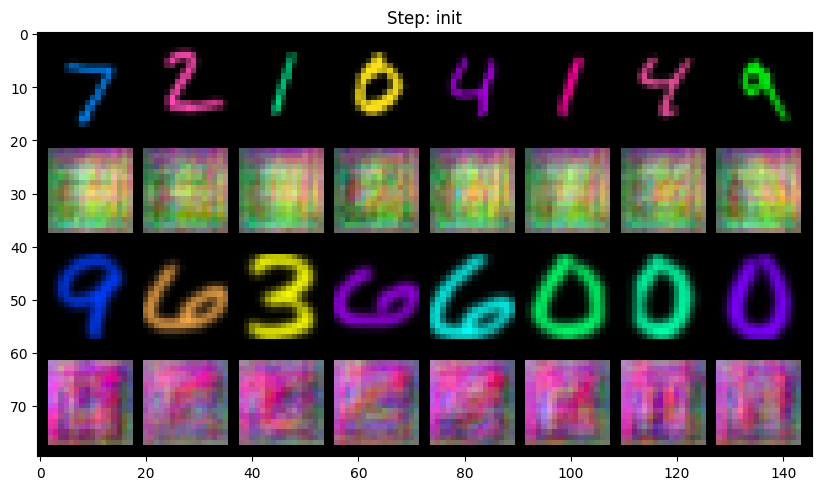

In [ ]:
show_cyclegan_images('init')

In [ ]:
MAX_STEPS = 1000

LAMBDA_CYCLE = 10.0
LAMBDA_ID = 5.0
visualize_steps = 1

In [ ]:
criterion_GAN = torch.nn.BCELoss() #Vanilla GAN loss
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size=1000):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        return data

In [ ]:
fake_X_buffer = ReplayBuffer()
fake_Y_buffer = ReplayBuffer()

SM = StatsManager('D_loss', 'G_loss')

Step 999


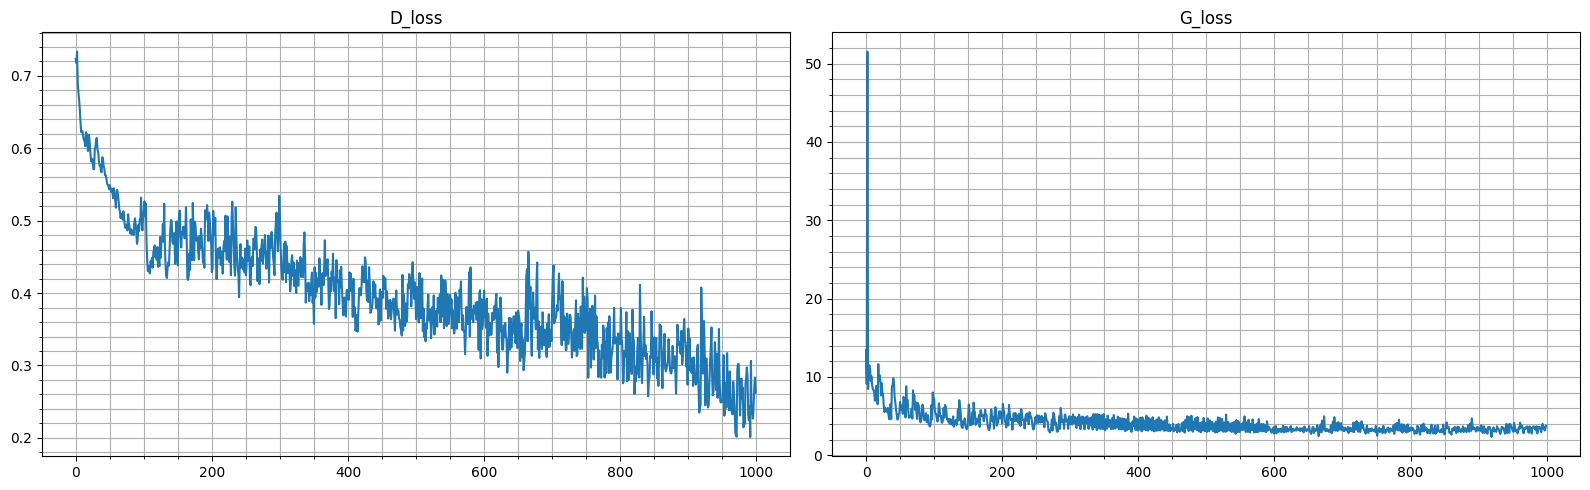

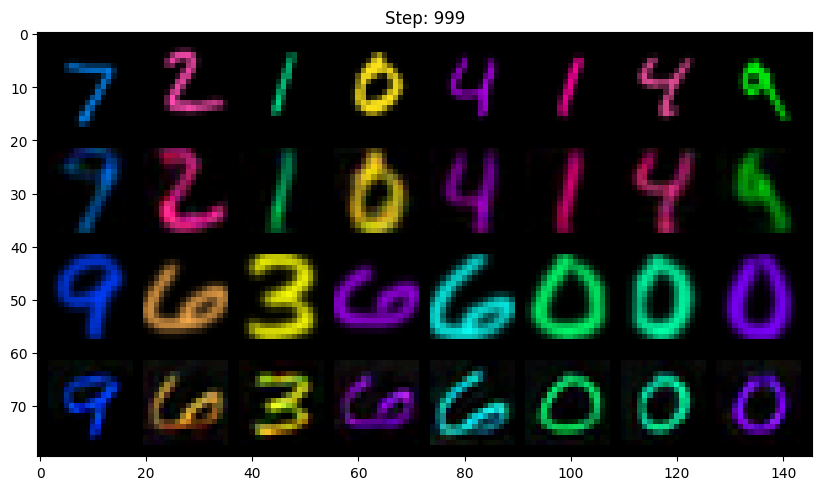

100%|██████████| 1000/1000 [23:06<00:00,  1.39s/it]


In [ ]:
for step in tqdm(range(MAX_STEPS)):

    # Set model input
    real_X = sample_mnist()
    real_X = torch.tensor(real_X, device=DEVICE)

    real_Y = sample_usps()
    real_Y = torch.tensor(real_Y, device=DEVICE)

    # Adversarial ground truths
    valid = torch.ones((real_X.size(0), *D_X.output_shape), device=DEVICE)
    fake = torch.zeros((real_X.size(0), *D_X.output_shape), device=DEVICE)

    ##################
    #  Train Generators for both domains X and Y

    G_XY.train()
    G_YX.train()

    optimizer_G.zero_grad()

    # Identity loss
    loss_id_X = criterion_identity(G_YX(real_X), real_X)
    loss_id_Y = criterion_identity(G_XY(real_Y), real_Y)

    loss_identity = (loss_id_X + loss_id_Y) / 2

    # GAN loss
    fake_Y = G_XY(real_X)
    loss_GAN_XY = criterion_GAN(torch.sigmoid(D_Y(fake_Y)), valid)
    fake_X = G_YX(real_Y)
    loss_GAN_YX = criterion_GAN(torch.sigmoid(D_X(fake_X)), valid)

    loss_GAN = (loss_GAN_XY + loss_GAN_YX) / 2

    # Cycle loss
    recov_X = G_YX(fake_Y)
    loss_cycle_X = criterion_cycle(recov_X, real_X)
    recov_Y = G_XY(fake_X)
    loss_cycle_Y = criterion_cycle(recov_Y, real_Y)

    loss_cycle = (loss_cycle_X + loss_cycle_Y) / 2

    # Total loss
    loss_G = loss_GAN + LAMBDA_CYCLE * loss_cycle + LAMBDA_ID * loss_identity

    loss_G.backward()
    optimizer_G.step()

    SM.upd('G_loss', loss_G.item())

    #####################
    #  Train Discriminator for domain X

    D_X.train()

    optimizer_D_X.zero_grad()

    # Real loss
    loss_real = criterion_GAN(torch.sigmoid(D_X(real_X)), valid)
    # Fake loss (on batch of previously generated samples)
    fake_X_ = fake_X_buffer.push_and_pop(fake_X)
    loss_fake = criterion_GAN(torch.sigmoid(D_X(fake_X_.detach())), fake)
    # Total loss
    loss_D_X = (loss_real + loss_fake) / 2

    loss_D_X.backward()
    optimizer_D_X.step()

    ####################
    #  Train Discriminator for domain Y

    D_Y.train()

    optimizer_D_Y.zero_grad()

    # Real loss
    loss_real = criterion_GAN(torch.sigmoid(D_Y(real_Y)), valid)
    # Fake loss (on batch of previously generated samples)
    fake_Y_ = fake_Y_buffer.push_and_pop(fake_Y)
    loss_fake = criterion_GAN(torch.sigmoid(D_Y(fake_Y_.detach())), fake)
    # Total loss
    loss_D_Y = (loss_real + loss_fake) / 2

    loss_D_Y.backward()
    optimizer_D_Y.step()

    loss_D = (loss_D_X + loss_D_Y) / 2

    SM.upd('D_loss', loss_D.item())

    # Visualization
    if visualize_steps and step % visualize_steps == 0:
        clear_output(wait=True)
        print('Step {}'.format(step))
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        SM.draw(axes)
        plt.tight_layout()
        plt.show()

        show_cyclegan_images(step)
        plt.show()
        plt.close(fig)


In [1]:
# 4 Результаты переноса изображены выше
# Первая строка: оригинальные образцы из MNIST.
# Вторая строка: сгенерированные образцы из MNIST в USPS 𝐺𝑋𝑌(𝑋).
# Третья строка: оригинальные образцы из USPS.
# Четвертая строка: сгенерированные образцы из USPS в MNIST  𝐺𝑌𝑋(𝑌).


# Выводы:

# Включение L1 регуляризации способствует сохранению структуры оригинальных изображений,
# что позволяет генератору не только создавать правдоподобные изображения, но и поддерживать их
# сходство с целевым доменом (USPS). Это помогает улучшить качество генерации и повысить стабильность обучения.
# Модель успешно учится на разрозненных данных и производит изображения,
# которые выглядят как естественные примеры из целевого домена.

In [ ]:
#HW2

In [1]:
def sq_cost (X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

COST = sq_cost

In [2]:
#1

from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt


BATCH_SIZE = 64

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def random_color(im):
    hue = 360*np.random.rand()
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

TRANSFORM = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    random_color,
    transforms.Normalize([0.5],[0.5])
])

def filter_mnist(dataset, digits):
    indices = [i for i, target in enumerate(dataset.targets) if target in digits]
    return Subset(dataset, indices)

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM)
usps_train = datasets.USPS(root='./data', train=True, download=True, transform=TRANSFORM)

mnist_train = filter_mnist(mnist_train, [1, 4])

mnist_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
usps_loader = torch.utils.data.DataLoader(usps_train, batch_size=BATCH_SIZE, shuffle=True)

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM)
usps_test = datasets.USPS(root='./data', train=False, download=True, transform=TRANSFORM)

mnist_test = filter_mnist(mnist_test, [1, 4])

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE)
usps_test_loader = torch.utils.data.DataLoader(usps_test, batch_size=BATCH_SIZE)

X_test_fixed = next(iter(mnist_test_loader))[0]
Y_test_fixed = next(iter(usps_test_loader))[0]

del mnist_test_loader, usps_test_loader, mnist_test, usps_test

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34644231.90it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1089251.81it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 7877757.74it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2975250.47it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 6579383/6579383 [00:01<00:00, 4488512.66it/s]


100%|██████████| 1831726/1831726 [00:01<00:00, 1616350.06it/s]


Random (unpaired) images from MNIST (1st row) and USPS (2nd row) train sets


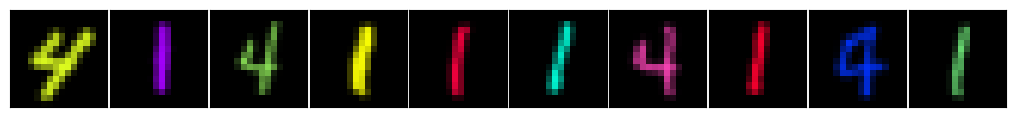

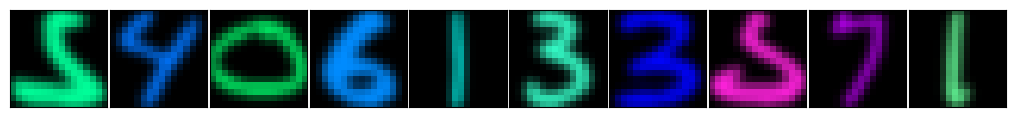

In [3]:
def plot_images(batch):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1), dpi=100)
    for i in range(10):
        axes[i].imshow(batch[i].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
        axes[i].set_xticks([]); axes[i].set_yticks([])
    fig.tight_layout(pad=0.1)

print('Random (unpaired) images from MNIST (1st row) and USPS (2nd row) train sets')
plot_images(next(iter(mnist_loader))[0])
plot_images(next(iter(usps_loader))[0])

In [4]:
iter_mnist, iter_usps = iter(mnist_loader), iter(usps_loader)

def sample_mnist():
    global iter_mnist, mnist_loader
    try:
        return next(iter_mnist)[0]
    except StopIteration:
        iter_mnist = iter(mnist_loader)
        return next(iter_mnist)[0]

def sample_usps():
    global iter_usps, usps_loader
    try:
        return next(iter_usps)[0]
    except StopIteration:
        iter_usps = iter(usps_loader)
        return next(iter_usps)[0]

In [5]:
#2


import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class TransportNet(nn.Module):
    def __init__(self):
        super(TransportNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Conv2d(128, 3, kernel_size=5, padding=2),
        )
    def forward(self, x):
        return self.model(x)

class PotentialNet(nn.Module):
    def __init__(self):
        super(PotentialNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.AvgPool2d(2), #  128 x 8 x 8
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.AvgPool2d(2), #  256 x 4 x 4
            nn.Conv2d(256, 512, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.AvgPool2d(2), #  512 x 2 x 2
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.AvgPool2d(2), #  512 x 1 x 1
            nn.Conv2d(512, 1, kernel_size=1, padding=0),
            nn.Flatten(1),
        )
    def forward(self, x):
        return -torch.abs(self.model(x))  # non-positive

In [ ]:
#3

COST = sq_cost

T_ITERS = 10
MAX_STEPS = 10000 + 1

# First experiment: w=1
w = 1

T = TransportNet().to(DEVICE)
f = PotentialNet().to(DEVICE)

T_opt = torch.optim.Adam(T.parameters(), lr=1e-4, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 2067971
f params: 6466817


Step 10000
Mnist images X, mapped images T(X), unpaired USPS images Y


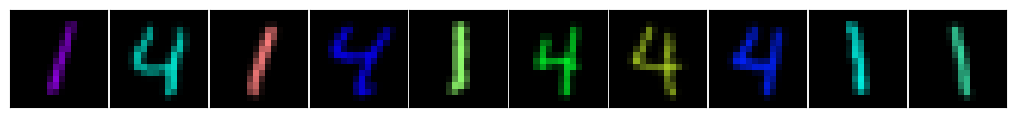

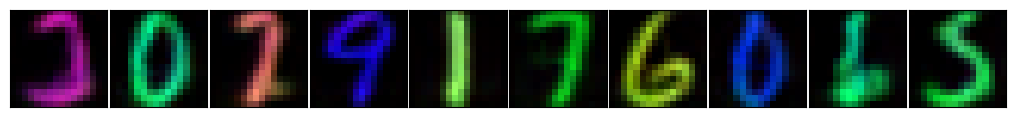

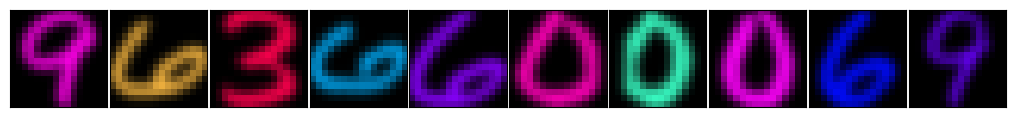

100%|██████████| 10001/10001 [1:40:34<00:00,  1.66it/s]


In [ ]:
from IPython.display import clear_output

for step in tqdm(range(MAX_STEPS)):
    T.train(True); f.eval()
    for t_iter in range(T_ITERS):
        X = sample_mnist()
        X = torch.tensor(X, device=DEVICE)
        T_loss = COST(X, T(X)).mean() - f(T(X)).mean()
        T_opt.zero_grad(); T_loss.backward(); T_opt.step()

    T.eval(); f.train(True)
    X, Y = sample_mnist(), sample_usps()
    X = torch.tensor(X, device=DEVICE)
    Y = torch.tensor(Y, device=DEVICE)
    f_loss = f(T(X)).mean() - w*(f(Y).mean())
    f_opt.zero_grad(); f_loss.backward(); f_opt.step()

    if step % 200 == 0:
        clear_output(wait=True)
        print("Step", step)

        with torch.no_grad():
            T_X_test_fixed = T(torch.tensor(X_test_fixed, device=DEVICE)).to('cpu')
        print('Mnist images X, mapped images T(X), unpaired USPS images Y')
        plot_images(X_test_fixed)
        plot_images(T_X_test_fixed)
        plot_images(Y_test_fixed)
        plt.show()

Step 10000
Mnist images X, mapped images T(X), unpaired USPS images Y


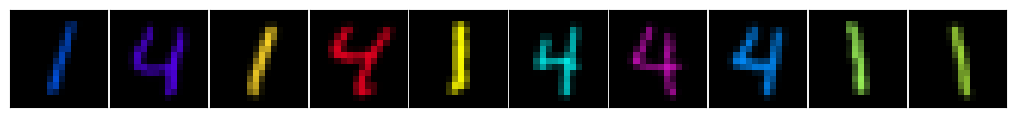

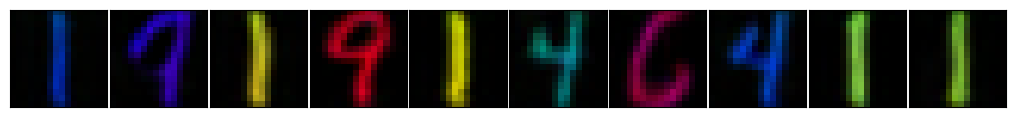

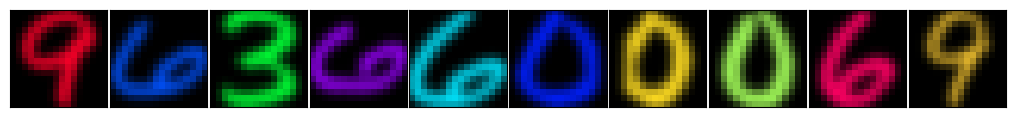

100%|██████████| 10001/10001 [1:37:31<00:00,  1.71it/s]


In [33]:
COST = sq_cost

T_ITERS = 10
MAX_STEPS = 10000 + 1

#Second experiment: w = 3
w = 3

T = TransportNet().to(DEVICE)
f = PotentialNet().to(DEVICE)

T_opt = torch.optim.Adam(T.parameters(), lr=1e-4, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))


from IPython.display import clear_output

for step in tqdm(range(MAX_STEPS)):
    T.train(True); f.eval()
    for t_iter in range(T_ITERS):
        X = sample_mnist()
        X = torch.tensor(X, device=DEVICE)
        T_loss = COST(X, T(X)).mean() - f(T(X)).mean()
        T_opt.zero_grad(); T_loss.backward(); T_opt.step()

    T.eval(); f.train(True)
    X, Y = sample_mnist(), sample_usps()
    X = torch.tensor(X, device=DEVICE)
    Y = torch.tensor(Y, device=DEVICE)
    f_loss = f(T(X)).mean() - w*(f(Y).mean())
    f_opt.zero_grad(); f_loss.backward(); f_opt.step()

    if step % 200 == 0:
        clear_output(wait=True)
        print("Step", step)

        with torch.no_grad():
            T_X_test_fixed = T(torch.tensor(X_test_fixed, device=DEVICE)).to('cpu')
        print('Mnist images X, mapped images T(X), unpaired USPS images Y')
        plot_images(X_test_fixed)
        plot_images(T_X_test_fixed)
        plot_images(Y_test_fixed)
        plt.show()

Step 10000
Mnist images X, mapped images T(X), unpaired USPS images Y


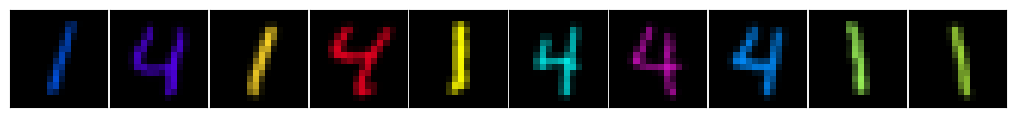

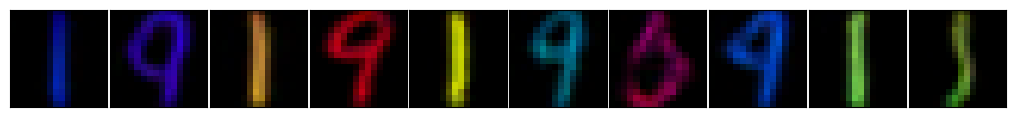

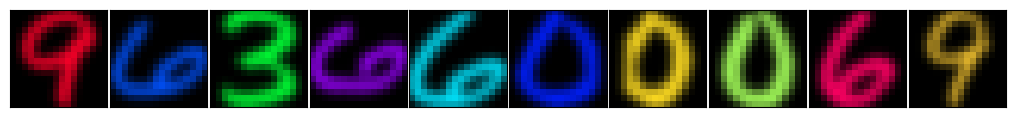

100%|██████████| 10001/10001 [1:37:33<00:00,  1.71it/s]


In [6]:
COST = sq_cost

T_ITERS = 10
MAX_STEPS = 10000 + 1

#Third experiment: w = 5
w = 5

T = TransportNet().to(DEVICE)
f = PotentialNet().to(DEVICE)

T_opt = torch.optim.Adam(T.parameters(), lr=1e-4, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))


from IPython.display import clear_output

for step in tqdm(range(MAX_STEPS)):
    T.train(True); f.eval()
    for t_iter in range(T_ITERS):
        X = sample_mnist()
        X = torch.tensor(X, device=DEVICE)
        T_loss = COST(X, T(X)).mean() - f(T(X)).mean()
        T_opt.zero_grad(); T_loss.backward(); T_opt.step()

    T.eval(); f.train(True)
    X, Y = sample_mnist(), sample_usps()
    X = torch.tensor(X, device=DEVICE)
    Y = torch.tensor(Y, device=DEVICE)
    f_loss = f(T(X)).mean() - w*(f(Y).mean())
    f_opt.zero_grad(); f_loss.backward(); f_opt.step()

    if step % 200 == 0:
        clear_output(wait=True)
        print("Step", step)

        with torch.no_grad():
            T_X_test_fixed = T(torch.tensor(X_test_fixed, device=DEVICE)).to('cpu')
        print('Mnist images X, mapped images T(X), unpaired USPS images Y')
        plot_images(X_test_fixed)
        plot_images(T_X_test_fixed)
        plot_images(Y_test_fixed)
        plt.show()

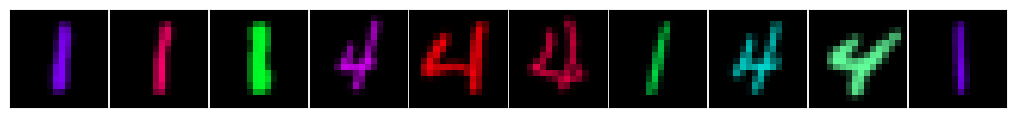

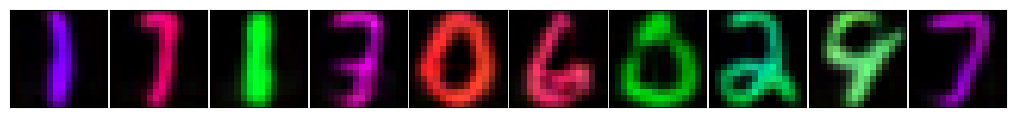

In [ ]:
    #6
    #Демонстрация генерации: w = 1

    mnist_test_batch = next(iter(mnist_loader))[0].cuda()
    with torch.no_grad():
        translated_images = T(mnist_test_batch
                              )
    plot_images(mnist_test_batch.cpu())
    plot_images(translated_images.cpu())

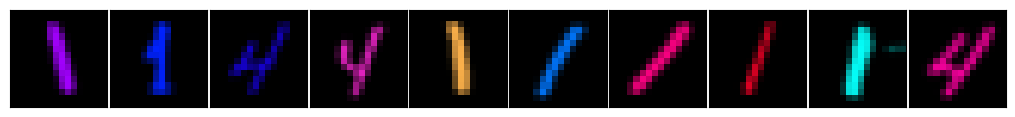

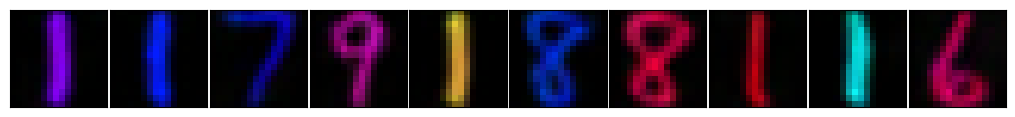

In [34]:
#Демонстрация генерации: w = 3

mnist_test_batch = next(iter(mnist_loader))[0].cuda()
with torch.no_grad():
    translated_images = T(mnist_test_batch)
plot_images(mnist_test_batch.cpu())
plot_images(translated_images.cpu())

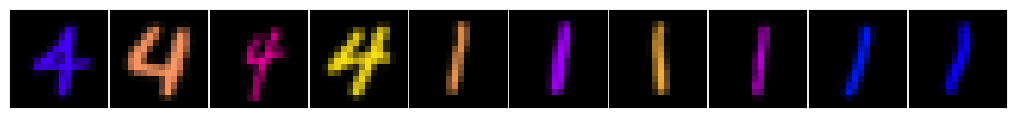

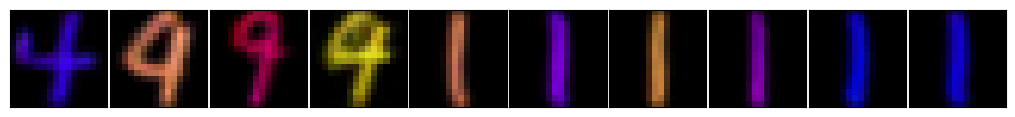

In [32]:
#Демонстрация генерации: w = 5

mnist_test_batch = next(iter(mnist_loader))[0].cuda()
with torch.no_grad():
    translated_images = T(mnist_test_batch)
plot_images(mnist_test_batch.cpu())
plot_images(translated_images.cpu())

In [ ]:
# Выводы:

# При w=1:
# Перенос осуществляется полноценно, но модель смешивает классы и цвета, что ухудшает качество результата.
# Так как при w=1 алгоритм совпадает с алгоритмом НОТ, у него возникают сложности c сохранением информации, поскольку НОТ
# решает задачу переноса исходного распределения во все целевое распределение, которое содержит лишние классы и цвета цифр.
# При w=3:
# Увеличение параметра w приводит к более аккуратному подбору целевых изображений.
# Модель лучше сохраняет классовую и цветовую принадлежность, но может быть склонна к ошибкам (особенно у класса).

# При w=5:
# Слишком высокая величина параметра приводит к сильной фильтрации и потере значительного количества данных,
# что ухудшает качество отображения. Однако было замечено, что сохранение классовой принадлежности при этом параметре
# немного выше, чем при w=3.

# При большом параметре w модель станет слишком избирательной, и некоторые детали или вариации в изображениях потеряются.
# В итоге, несмотря на хорошее сохранение класса и цвета, результат может стать слишком ограниченным

# Оптимальным параметром является число, близкое к 3
# На графиках обучения видно (при w=1,3,5), что результат при w=3 оптимальный, при w=5 хуже качество изображения.
